# *Quick, Draw!* GAN

이 노트북에서 ([MIT License](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/LICENSE)의 [Rowel Atienza의 코드](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/Experiments/Tensorflow/GAN/dcgan_mnist.py)를 바탕으로) 생성적 적대 신경망을 만들고 [*Quick, Draw!* 게임](https://quickdraw.withgoogle.com)([Creative Commons Attribution 4.0 라이센스](https://creativecommons.org/licenses/by/4.0/)이며 [여기](https://github.com/googlecreativelab/quickdraw-dataset)에서 다운로드할 수 있습니다) 스타일의 스케치를 만듭니다.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rickiepark/dl-illustrated/blob/master/notebooks/12-1.generative_adversarial_network.ipynb)

_이 노트북에서 효과적으로 훈련을 수행하려면 GPU를 사용하는 것이 좋습니다. 대부분 독자들의 컴퓨터에 있는 GPU는 텐서플로 계산에 사용할 수 없지만 (즉 CUDA와 cuDNN이 설치된 Nvidia GPU가 없겠지만) [코랩(Colab)](https://colab.research.google.com/)에서 무료로 사용할 수 있습니다._

#### 라이브러리 적재

In [ ]:
# 데이터 입력과 출력을 위해
import numpy as np
import os

# 딥러닝 모델을 위해
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape # new! 
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D # new! 
from tensorflow.keras.optimizers import RMSprop # new! 

# 출력을 위해 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### 데이터 적재
넘파이 비트맵 파일은 [여기](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap)에서 다운로드할 수 있습니다. *apple*을 사용할 필요는 없습니다. 원하는 카테고리를 다운로드해도 됩니다. :)

_역주: 편의를 위해 원드라이브에서 `apple.npy` 파일을 직접 다운로드합니다._

In [ ]:
!rm -rf ../quickdraw_data
!mkdir ../quickdraw_data
!wget https://bit.ly/3aJPabM -O ../quickdraw_data/apple.npy

--2021-02-02 21:52:46--  https://bit.ly/3b9KpIf
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://onedrive.live.com/download?cid=822579D69D2DC3B5&resid=822579D69D2DC3B5!597496&authkey=ACSk3FF_gq_U594 [following]
--2021-02-02 21:52:46--  https://onedrive.live.com/download?cid=822579D69D2DC3B5&resid=822579D69D2DC3B5!597496&authkey=ACSk3FF_gq_U594
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://fnaxrg.bl.files.1drv.com/y4mV8z8o3DQ9SyXbARLlFGo2ic56xQN87uXLGvpg19_JBIaW92AJSEXKA5L5OLWFhVrEpIqE3LSmXKgKIKmOgvC6JiyfTowOnKG73WaQ4rcI1czbivNZ0dCfYuWZQey-qDUD-TcSrdrhkxzvIbKOnqae5y86_-zDjQXHUq08AxegXcsxg5oPW-qnuhVVysQTqXBcHRD6W6w3lK5i9kDtnS-tQ/full_numpy_bitmap_apple.npy?download&psid=1

In [ ]:
input_images = "../quickdraw_data/apple.npy"

In [ ]:
data = np.load(input_images) # 넘파이 .npy 포맷의 (친숙한) 28x28 흑백 비트맵. 이미지는 중앙에 맞춰져 있습니다.

In [ ]:
data.shape

(144722, 784)

In [ ]:
data[4242]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  36,  79,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 134, 238,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 119, 254,   4,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 101, 255,  21,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  82, 255,  39,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # 컬러 채널을 위해 4차원으로 바꿉니다.
img_w,img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

In [ ]:
data[4242]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.14117647],
        [0.30980392],
        [0.        ],
        [0.        ],
        

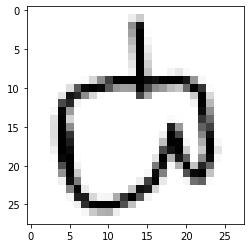

In [ ]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

#### 판별자 만들기

In [ ]:
def build_discriminator(depth=64, p=0.4):

    # 입력
    image = Input((img_w,img_h,1))
    
    # 합성곱 층
    conv1 = Conv2D(depth*1, 5, strides=2, 
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, 
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, 
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, 
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # 출력층
    prediction = Dense(1, activation='sigmoid')(conv4)
    
    # 모델 생성
    model = Model(inputs=image, outputs=prediction)
    
    return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0     

In [ ]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, 
                                        decay=6e-8, 
                                        clipvalue=1.0), 
                      metrics=['accuracy'])

#### 생성자 만들기

In [ ]:
z_dimensions = 32

In [ ]:
def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # 입력
    noise = Input((latent_dim,))
    
    # 첫 번째 은닉층
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # 전치합성곱 층
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # 출력층
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # 모델 생성
    model = Model(inputs=noise, outputs=image)
    
    return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0   

#### GAN 만들기

In [ ]:
z = Input(shape=(z_dimensions,))
img = generator(z)

In [ ]:
discriminator.trainable = False

In [ ]:
pred = discriminator(img)

In [ ]:
adversarial_model = Model(z, pred)

In [ ]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=RMSprop(lr=0.0004, 
                                            decay=3e-8, 
                                            clipvalue=1.0), 
                          metrics=['accuracy'])

#### 훈련!

In [ ]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        # 진짜 이미지 샘플링 
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))
        
        # 가짜 이미지 생성
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
        
        # 판별자에게 전달하기 위해 이미지를 합치기
        x = np.concatenate((real_imgs,fake_imgs))
        
        # 판별자에게 전달하기 위해 y 레이블 설정하기
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        # 판별자 훈련
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # GAN 신경망의 잡음 입력과 진짜 레이블 y
        noise = np.random.uniform(-1.0, 1.0, 
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # GAN 훈련
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        ) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # 훈련 과정과 생성한 가짜 이미지를 출력합니다.
        if (i+1)%100 == 0:

            print('에포크 #{}'.format(i))
            log_mesg = "%d: [D 손실: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A 손실: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

에포크 #99
99: [D 손실: 0.335540, acc: 0.935606]  [A 손실: 2.210987, acc: 0.408065]


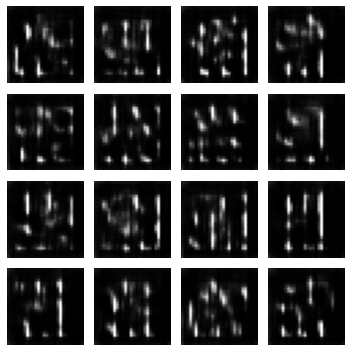

에포크 #199
199: [D 손실: 0.309171, acc: 0.921895]  [A 손실: 2.753029, acc: 0.231784]


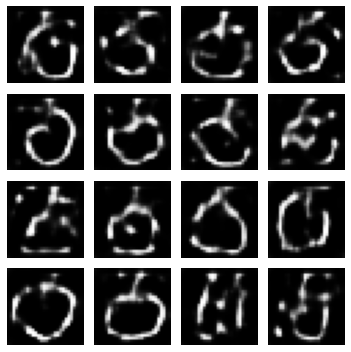

에포크 #299
299: [D 손실: 0.362601, acc: 0.879455]  [A 손실: 2.473866, acc: 0.198474]


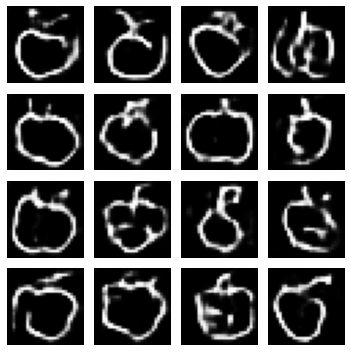

에포크 #399
399: [D 손실: 0.387157, acc: 0.855028]  [A 손실: 2.333179, acc: 0.184857]


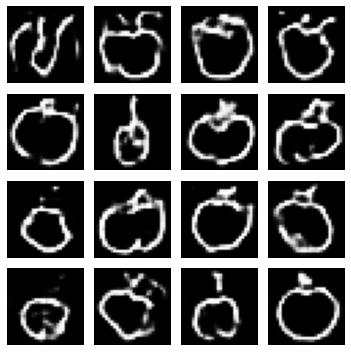

에포크 #499
499: [D 손실: 0.402889, acc: 0.841088]  [A 손실: 2.237857, acc: 0.175429]


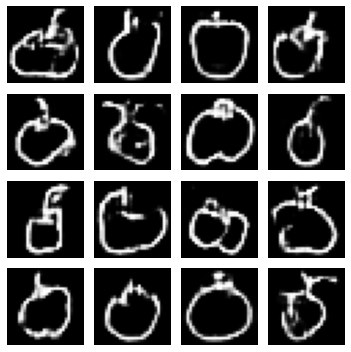

에포크 #599
599: [D 손실: 0.408402, acc: 0.833877]  [A 손실: 2.203279, acc: 0.167871]


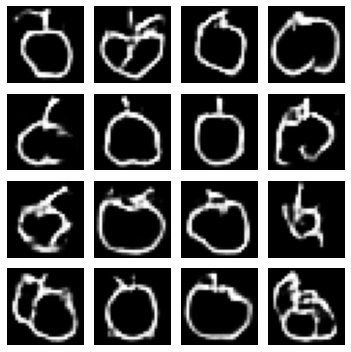

에포크 #699
699: [D 손실: 0.409062, acc: 0.830467]  [A 손실: 2.199274, acc: 0.162051]


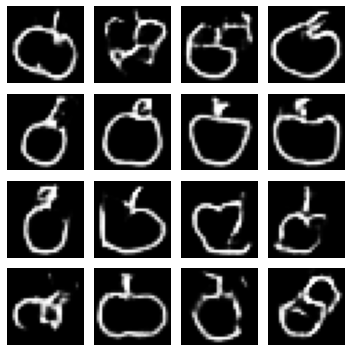

에포크 #799
799: [D 손실: 0.407340, acc: 0.829562]  [A 손실: 2.212471, acc: 0.157042]


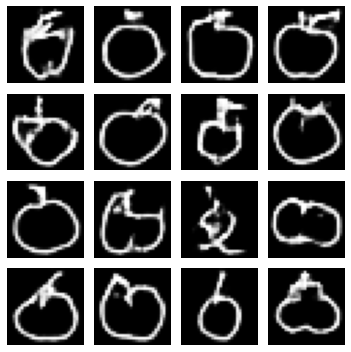

에포크 #899
899: [D 손실: 0.405513, acc: 0.828594]  [A 손실: 2.231492, acc: 0.152922]


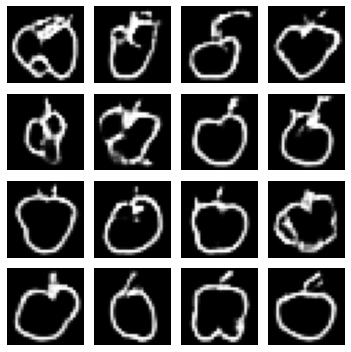

에포크 #999
999: [D 손실: 0.402898, acc: 0.828551]  [A 손실: 2.258227, acc: 0.149306]


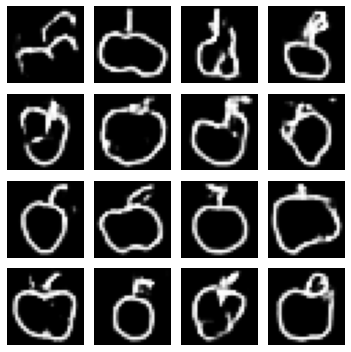

에포크 #1099
1099: [D 손실: 0.400334, acc: 0.828985]  [A 손실: 2.280035, acc: 0.146269]


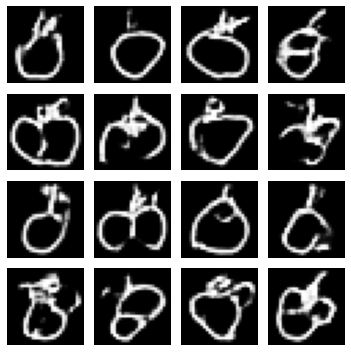

에포크 #1199
1199: [D 손실: 0.397368, acc: 0.829529]  [A 손실: 2.305961, acc: 0.143199]


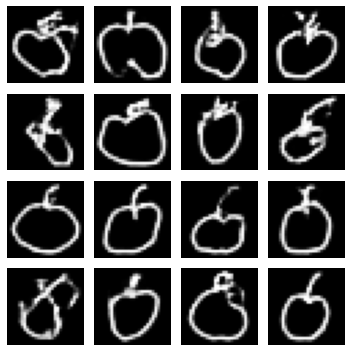

에포크 #1299
1299: [D 손실: 0.394516, acc: 0.830395]  [A 손실: 2.335837, acc: 0.140463]


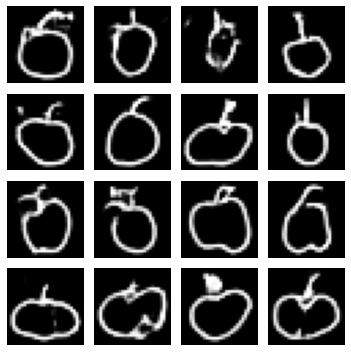

에포크 #1399
1399: [D 손실: 0.391446, acc: 0.831291]  [A 손실: 2.365714, acc: 0.138006]


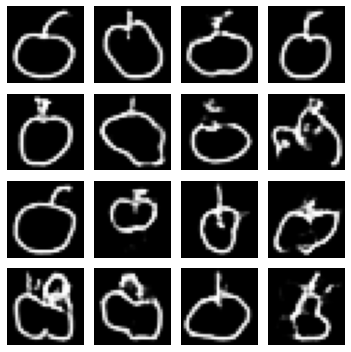

에포크 #1499
1499: [D 손실: 0.388126, acc: 0.832492]  [A 손실: 2.396573, acc: 0.135684]


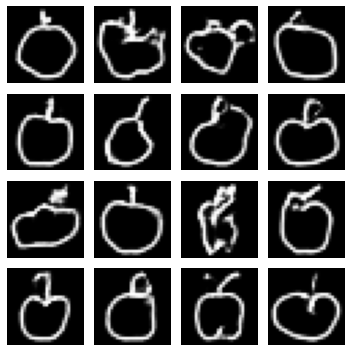

에포크 #1599
1599: [D 손실: 0.385389, acc: 0.833468]  [A 손실: 2.423063, acc: 0.133169]


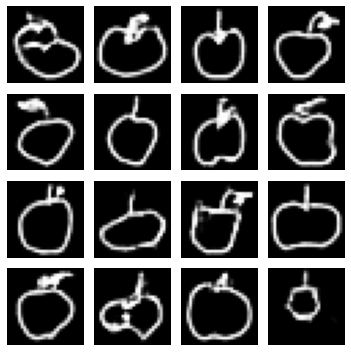

에포크 #1699
1699: [D 손실: 0.382780, acc: 0.834434]  [A 손실: 2.447013, acc: 0.131102]


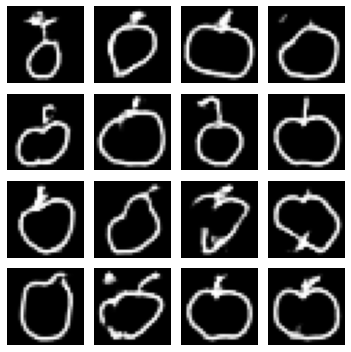

에포크 #1799
1799: [D 손실: 0.379977, acc: 0.835660]  [A 손실: 2.477214, acc: 0.129186]


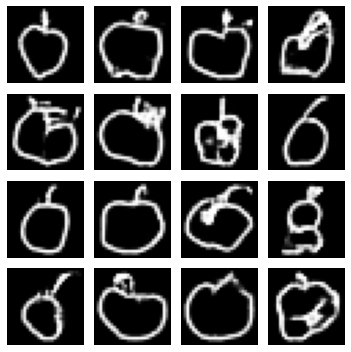

에포크 #1899
1899: [D 손실: 0.377346, acc: 0.836629]  [A 손실: 2.505946, acc: 0.127119]


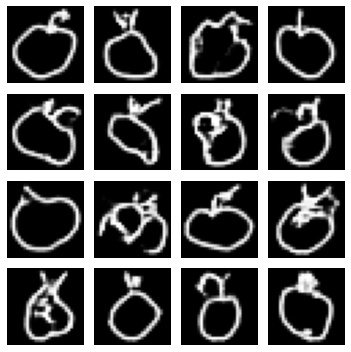

에포크 #1999
1999: [D 손실: 0.375082, acc: 0.837620]  [A 손실: 2.528053, acc: 0.125387]


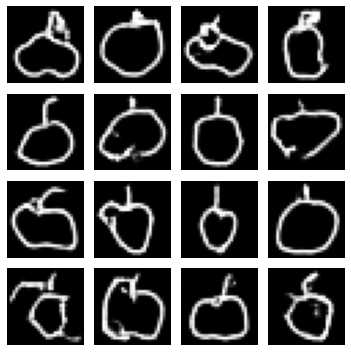

In [ ]:
a_metrics_complete, d_metrics_complete = train()

Text(0, 0.5, 'Loss')

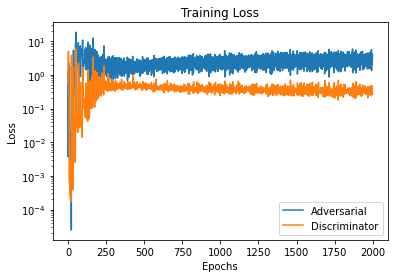

In [ ]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

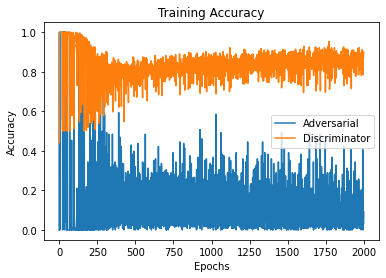

In [ ]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")